In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units
import pandas as pd
import scipy.interpolate
import scipy.integrate

Filename: ./data/mojaveepoch.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     121   ()      
  1  table2.dat    1 TableHDU       129   5321R x 17C   [A8, A20, A11, A1, F4.2, F4.2, I3, I5, F4.2, F5.2, A1, F6.1, F4.2, F5.2, I3, A2, I4]   
None


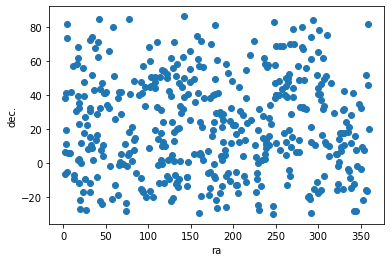

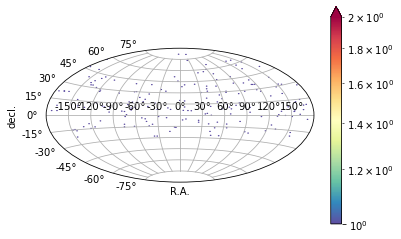

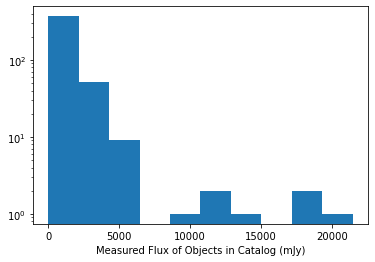

In [12]:
def open_and_convert_catalog(file_name, file_name2,output_file_name,aeff_file_name):
    
    #This loads the MOJAVE data from two file names bc the catalogue gives two different files
    #with the sources in different order! So I have to cross reference them here. 
    
    
    #This loads the first file and gets the flux density and the names
    hdul = fits.open(file_name)
    print(hdul.info())

    cat_names = np.array(hdul[1].data.field(0).tolist())
    cat_fluxdensity = np.array(hdul[1].data.field(7).tolist())
    
    #This loads the second file to get the names, location, redshift, and source type
    df = pd.DataFrame()    
    df = pd.concat([df, pd.read_csv(file_name2, header=None, skiprows=1)])
    names2=np.array(df[4].to_numpy())
    cat_ra=np.array(df[10].to_numpy())
    cat_dec=np.array(df[11].to_numpy())
    cat_z=np.array(df[27].to_numpy())
    cat_type=np.array(df[23].to_numpy())
    
    for i in range(len(cat_z)):
        if cat_z[i]=='nan':
            cat_z[i]=0
    
    unique_names=np.unique(names2)
    unique_cat_ra = np.zeros(len(unique_names))
    unique_cat_dec = np.zeros(len(unique_names))
    unique_cat_z = np.zeros(len(unique_names))
    unique_cat_type = (np.zeros(len(unique_names))).tolist()
    
    
    #Loading the effective area of the detector to go from flux to flux density
    """
    
    icecube_Aeff = np.load(aeff_file_name, allow_pickle=True)
    print(np.min(icecube_Aeff['Aeff']))
    f_Aeff_dec = scipy.interpolate.interp1d((icecube_Aeff['dec']),
                                            icecube_Aeff['Aeff'],
                                            kind='linear',
                                            bounds_error=False,
                                            fill_value="extrapolate")

    """
    
    
    #Because the catologue records the sources at a couple different times, I have to go and average
    #Various values to get one data point. That's what's going on here. I will probably have to modify this
    #For time dependent, since we want to look at each of the individual measurements. 
        
    for i_names, name in enumerate(unique_names):
        cur_ra = cat_ra[names2==name]
        unique_cat_ra[i_names]=np.mean(cur_ra)

        cur_dec = cat_dec[names2==name]
        unique_cat_dec[i_names]=np.mean(cur_dec)
        
        cur_z = cat_z[names2==name]
        unique_cat_z[i_names]=np.mean(cur_z)
       
        cur_type = cat_type[names2==name]
        unique_cat_type[i_names]=(cur_type[0])
   


        
    #Delete source 279 bc for some reason it is not in one of the data files (I forget which one)
    sources = np.unique(cat_names)
    sources = np.delete(sources,[279])
    unique_cat_fluxdensity = np.zeros(len(sources))
    
    #Here, I go through each source and average the flux value. Again, this will be altered for 
    #time dependent, but when I wrote this I was just trying to get an average. 
    
    for i_sources, source in enumerate(sources):
        cur_flux= cat_fluxdensity[cat_names==source]
        unique_cat_fluxdensity[i_sources]=np.mean(cur_flux)

        
    #Convert to CGS units
    """
    cat_fluxdensity = 1e-23*unique_cat_fluxdensity*(15398e6-15344e6)
    
    cat_fluxdensity = (1e3/1.602)*cat_fluxdensity
    """
    argsort_ = np.argsort(unique_cat_dec)
    
                
    np.savez(output_file_name,
             cat_names=sources,
             cat_ra=unique_cat_ra,
             cat_dec=unique_cat_dec,
             cat_type=unique_cat_type,
             cat_fluxdensity=unique_cat_fluxdensity,
             cat_z=unique_cat_z)

    
    
def plot_catalog(file_name):

    catalog_data = np.load(file_name)
    
    

    cat_fluxdensity = catalog_data['cat_fluxdensity']
    cat_ra = catalog_data['cat_ra']
    cat_dec = catalog_data['cat_dec']
    
    plt.figure()
    plt.scatter(cat_ra, cat_dec)
    plt.xlabel("ra")
    plt.ylabel("dec.")
    plt.show()
    coords = SkyCoord(ra=cat_ra,
                      dec=cat_dec,
                      unit='degree')

    ra = coords.ra.wrap_at(180 * units.deg).radian
    dec = coords.dec.radian
    color_map = plt.cm.Spectral_r

    ax = plt.subplot(111, projection="aitoff")
    image = ax.hexbin(ra, dec,
                      cmap=color_map,
                      gridsize=400,
                      mincnt=1,
                      bins='log')
    ax.set_xlabel('R.A.')
    ax.set_ylabel('decl.')
    ax.grid(True)
    cbar = plt.colorbar(image, spacing='uniform', extend='max')

    plt.figure()
    plt.hist(cat_fluxdensity,
             range=None,
             bins=10)
    plt.yscale('log')
    plt.xlabel("Measured Flux of Objects in Catalog (mJy)")

    
    
    plt.show()


if(__name__ == "__main__"):

    open_and_convert_catalog("./data/mojaveepoch.fits","./data/sources.csv",
                             "./processed_data/radio_catelogy.npz","./processed_data/output_icecube_Aeff_nointegral.npz")

    plot_catalog("./processed_data/radio_catelogy.npz")